# Casamento de pontos salientes

Iremos encontrar a posição de um objeto em uma imagem utilizando descritores SIFT

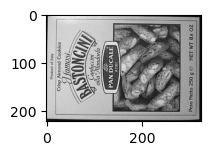

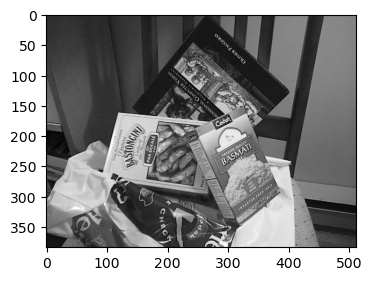

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

img_box = cv2.imread('../data/box.pgm',0)   
img_scene = cv2.imread('../data/scene.pgm',0) 

# Objeto de referência
plt.figure(figsize=[2,2])
plt.imshow(img_box, 'gray')
# Imagem a ser analisada
plt.figure(figsize=[4,4])
plt.imshow(img_scene, 'gray')

### 1. Detecção dos pontos salientes e criação dos descritores

In [2]:
sift = cv2.SIFT_create(
    nfeatures=0, 
    nOctaveLayers=3, 
    contrastThreshold=0.04, 
    edgeThreshold=10, 
    sigma=1.6
    )

kp_box, des_box = sift.detectAndCompute(img_box, None)
kp_scene, des_scene = sift.detectAndCompute(img_scene, None)

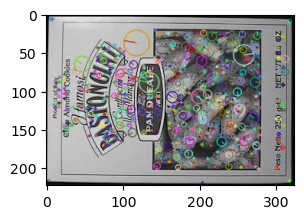

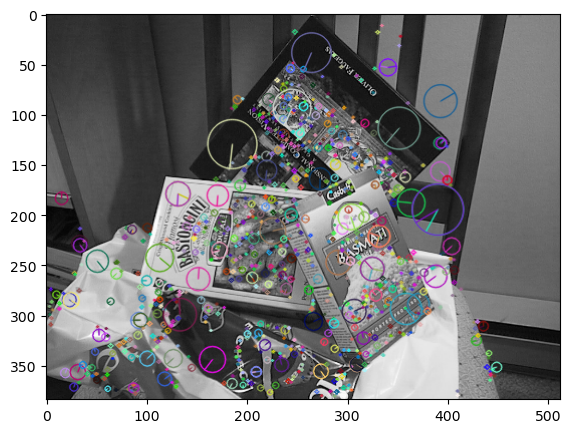

In [18]:
image_kp_box = cv2.drawKeypoints(img_box, kp_box, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image_kp_box)

image_kp_scene = cv2.drawKeypoints(img_scene, kp_scene, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=[7, 5])
plt.imshow(image_kp_scene)

### 2. Casamento dos pontos salientes detectados

Usaremos o método BFMatcher (brute force matcher) para encontrar os pontos salientes mais parecidos entre as imagens. Esse método calcula a distância Euclideana entre os descritores e retorna os pares de descritores mais próximos.

In [20]:
# Cria o objeto
# crossCheck=True indica que o método deve retornar apenas pontos salientes 
# p1 e p2 para os quais p2 é o ponto mais próximo de p1 e p1 é o ponto mais
# próximo de p2
matcher = cv2.BFMatcher(crossCheck=False)

# Aplica o casamento
# k=2 indica que para cada ponto saliente de uma imagem queremos os 2 pontos
# mais próximos da outra imagem
matches = matcher.knnMatch(des_box, des_scene, k=2)

# Lista dos 2 pontos mais próximos para o ponto saliente 0 de `des_box`
matches_kp0 = matches[0]
# Para o ponto saliente 0 de `des_box`, esse é o ponto saliente de `des_scene`
# mais próximo
matching_kp = matches_kp0[0]

# Imprime as informações dos pontos
print('Closest match')
print("Keypoint index: {}, matching keypoint index: {}, distance: {}".format(
        matching_kp.queryIdx, matching_kp.trainIdx, matching_kp.distance))

matching_kp = matches_kp0[1]
print('Second closest match')
print("Keypoint index: {}, matching keypoint index: {}, distance: {}".format(
        matching_kp.queryIdx, matching_kp.trainIdx, matching_kp.distance))

Closest match
Keypoint index: 0, matching keypoint index: 336, distance: 212.0023651123047
Second closest match
Keypoint index: 0, matching keypoint index: 717, distance: 256.8598937988281


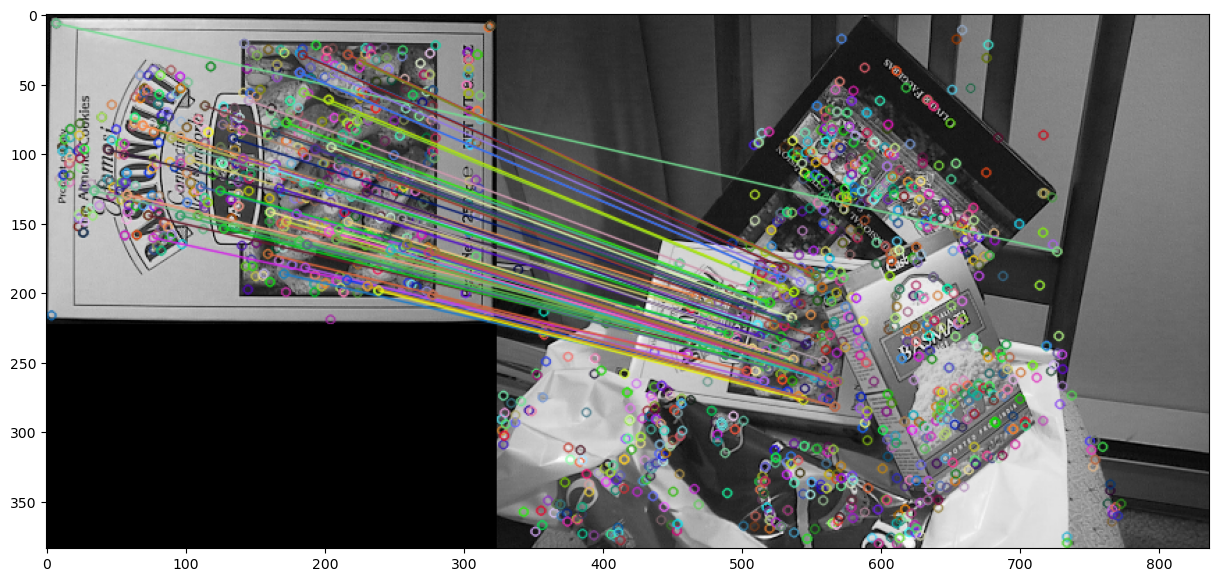

In [21]:
# Encontra bons pares de pontos utilizando o teste de Lowe
threshold = 0.7
good_matches = []
for m1, m2 in matches:
    closest_kp_distance = m1.distance
    second_closest_kp_distance = m2.distance
    # Bons pares de pontos possuem alta similaridade entre si em relação ao
    # segundo ponto mais próximo
    if closest_kp_distance/second_closest_kp_distance < threshold:
        good_matches.append(m1)

img_matches = cv2.drawMatches(img_box, kp_box, img_scene, kp_scene, good_matches, None)

plt.figure(figsize=[15,8])
plt.imshow(img_matches, 'gray')

### 3. Cálculo da transformação

In [22]:
# Cria array numpy com todas as posições dos pontos salientes
box_kp_pos = np.zeros((len(good_matches), 2), dtype=np.float32)
scene_kp_pos = np.zeros((len(good_matches), 2), dtype=np.float32)
for i, m in enumerate(good_matches):
    box_kp_pos[i] = kp_box[m.queryIdx].pt
    scene_kp_pos[i] = kp_scene[m.trainIdx].pt
    
# Encontra a transformação geométrica que melhor mapeia os pontos `box_kp_pos`
# nos pontos `scene_kp_pos`
# `t_matrix` é uma matriz de transformação e inliners é uma máscara indicando
# quais pontos são inliers
t_matrix, inliers = cv2.findHomography(
    box_kp_pos, 
    scene_kp_pos, 
    cv2.RANSAC,                 # Utiliza método RANSAC
    ransacReprojThreshold=3.0   # Limiar para considerar os pontos inliers
    ) 
inliers = inliers.flatten().tolist()

print(t_matrix)

[[ 4.42733084e-01 -1.59297594e-01  1.18656036e+02]
 [ 5.11707061e-04  4.10639233e-01  1.60840490e+02]
 [-2.47785577e-04 -3.30161024e-04  1.00000000e+00]]


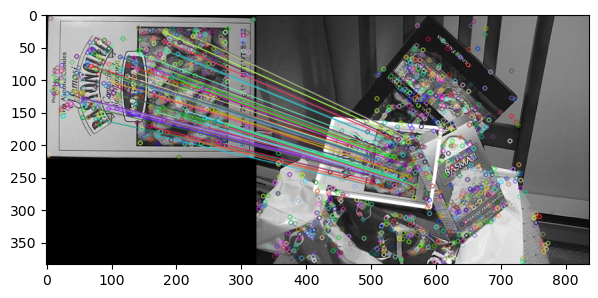

In [32]:
# Retângulo representando a caixa a ser buscada
h, w = img_box.shape
box_bounds = ((0, 0), (0, h-1), (w-1, h-1), (w-1, 0))
# Formato dos pontos esperado pelo OpenCV
box_bounds = np.array(box_bounds, dtype=np.float32).reshape(-1,1,2)
# Aplica a transformação
box_bounds_in_scene = cv2.perspectiveTransform(box_bounds, t_matrix)

# Desenha o retângulo transformado
img_scene_box = cv2.polylines(img_scene.copy(), [np.int32(box_bounds_in_scene)], True, 255, 3, cv2.LINE_AA)

# Mostra o retângulo transformado e os pontos salientes utilizados (inliers)
img_matches_ransac = cv2.drawMatches(img_box, kp_box, img_scene_box, kp_scene, good_matches, None, matchesMask=inliers)
plt.figure(figsize=[7,5])
plt.imshow(img_matches_ransac, 'gray')